*A notebook on a naive shrinkage correction approach where we just run PCA holding 1 single sample at a time for every sample ...*

# Imports

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

import pcshrink

# Functions

In [29]:
def holdout_pca(z, Z, K):
    """
    """
    n = Z.shape[1]
    pca = PCA(K)
    pca.fit(Z.T)
    F_hat = pca.components_.T
    
    l = (F_hat.T @ z)

    return(l)

# Data prep

In [4]:
%%time
data = pcshrink.UnpackedAncestryMap("/project/jnovembre/jhmarcus/ancient-sardinia/data/ref_genotypes/7-11-2018/lazaridis_2014/data_fil")

CPU times: user 8.72 s, sys: 2.58 s, total: 11.3 s
Wall time: 7.72 s


In [5]:
print(data.n, data.p)

777 594924


Find snps that are too rare or too common

In [6]:
# use allele frequency estimator from Price et al. 2006
f = (1. + np.nansum(data.Y, axis=1)) / (2 + (2. * data.n))

# keep snps that aren't too rare or common
snp_idx = np.where((f > .02) & (f < .98))[0]
print(f.shape, snp_idx.shape)

(594924,) (426765,)


Mean center and scale and impute missing values to 0

In [7]:
Z = data.Y[snp_idx, :]

# mean genotype 
mu = np.nanmean(Z, axis=1).reshape(len(snp_idx), 1)

# empirical std deviation
std = np.nanstd(Z, axis=1).reshape(len(snp_idx), 1)

# heterozygosity scaler
het = np.sqrt(2. * f[snp_idx] * (1. - f[snp_idx])).reshape(len(snp_idx), 1)

Z = (Z - mu) / het
Z[np.isnan(Z)] = 0.0

Text(0,0.5,'Emprical Std')

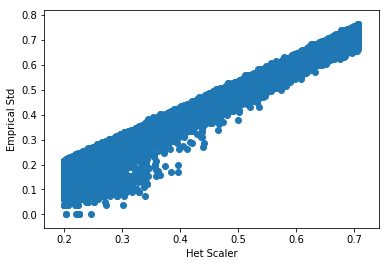

In [8]:
plt.scatter(het, std)
plt.xlabel("Het Scaler")
plt.ylabel("Emprical Std")

# PCA

In [9]:
%%time
pca = PCA(data.n, svd_solver="full")
pca.fit(Z.T)

CPU times: user 2min 39s, sys: 15.9 s, total: 2min 54s
Wall time: 9.28 s


snp weights

In [10]:
F_hat = pca.components_.T
F_hat.shape

(426765, 777)

coordinates 

In [11]:
L = (F_hat.T @ Z).T 
L = L / np.linalg.norm(L, axis=0, ord=2)

Plot PC1 vs PC2

Text(0,0.5,'PC2')

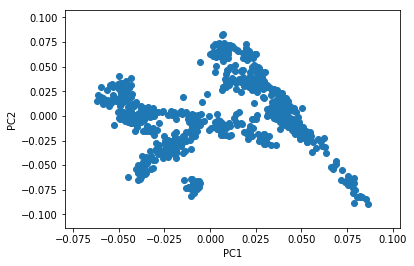

In [12]:
plt.scatter(L[:, 0], -L[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")

In [ ]:
%%time
K = 10
q = data.n
L_proj = np.empty((q, K))
for i in range(q):
    
    print(i)
    
    idx = np.ones(data.n, dtype="bool")
    idx[i] = False
    
    z = Z[:, i]
    Z_train = Z[:, idx]
    
    L_proj[i, :] = holdout_pca(z, Z_train, K)

0
1
2
3
4


In [31]:
L_proj = L_proj / np.linalg.norm(L_proj, axis=0, ord=2)

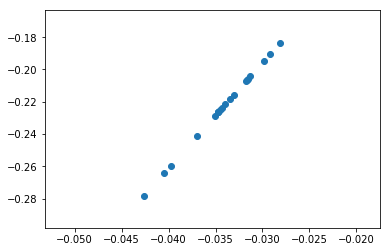

In [32]:
plt.scatter(L[:20, 0], L_proj[:,0])

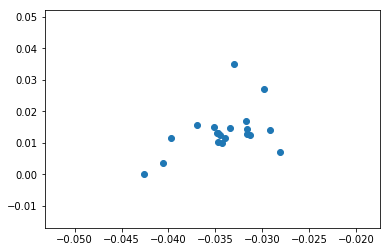

In [33]:
plt.scatter(L[:20, 0], L[:20, 1])

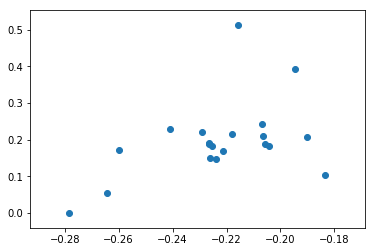

In [34]:
plt.scatter(L_proj[:, 0], L_proj[:, 1])